<a href="https://colab.research.google.com/github/shanmugasundaram1996/News-Article-Classification-Project-/blob/main/News_Article_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import time
import json
import joblib
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk
import re
import string
import emoji
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import RobertaTokenizerFast, TFRobertaModel
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TextClassificationPipeline,
    Trainer,
    TrainingArguments,
    pipeline
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load training data
train_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "amananandrai/ag-news-classification-dataset",
    "train.csv"
)

# Load testing data
test_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "amananandrai/ag-news-classification-dataset",
    "test.csv"
)

print("Train sample:", train_df.head())
print("Test sample:", test_df.head())

/tmp/ipython-input-4106562484.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  train_df = kagglehub.load_dataset(


100%|██████████| 10.7M/10.7M [00:00<00:00, 40.3MB/s]

Extracting zip of train.csv...



/tmp/ipython-input-4106562484.py:12: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  test_df = kagglehub.load_dataset(


Train sample:    Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
Test sample:    Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Private Team Sets Launc...   
2            4      K

Class Index


Consists of class ids 1-4 where

 1-World,

 2-Sports,

  3-Business,
  
  4-Sci/Tech

In [ ]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [ ]:
df.set_index('Class Index', inplace=True)

# Concatenate 'Title' and 'Description' into a single text field
df['text'] = df['Title'] + " " + df['Description']

# Adjust labels: convert to 0-based index
df['label'] = df.index-1

# Preview the processed DataFrame
print(df.head())

                                                         Title  \
Class Index                                                      
3            Wall St. Bears Claw Back Into the Black (Reuters)   
3            Carlyle Looks Toward Commercial Aerospace (Reu...   
3              Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            Iraq Halts Oil Exports from Main Southern Pipe...   
3            Oil prices soar to all-time record, posing new...   

                                                   Description  \
Class Index                                                      
3            Reuters - Short-sellers, Wall Street's dwindli...   
3            Reuters - Private investment firm Carlyle Grou...   
3            Reuters - Soaring crude prices plus worries\ab...   
3            Reuters - Authorities have halted oil export\f...   
3            AFP - Tearaway world oil prices, toppling reco...   

                                                          text  label  
Cl

/tmp/ipython-input-614353606.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  freq_matrix = freq_matrix.fillna(0).astype(int)


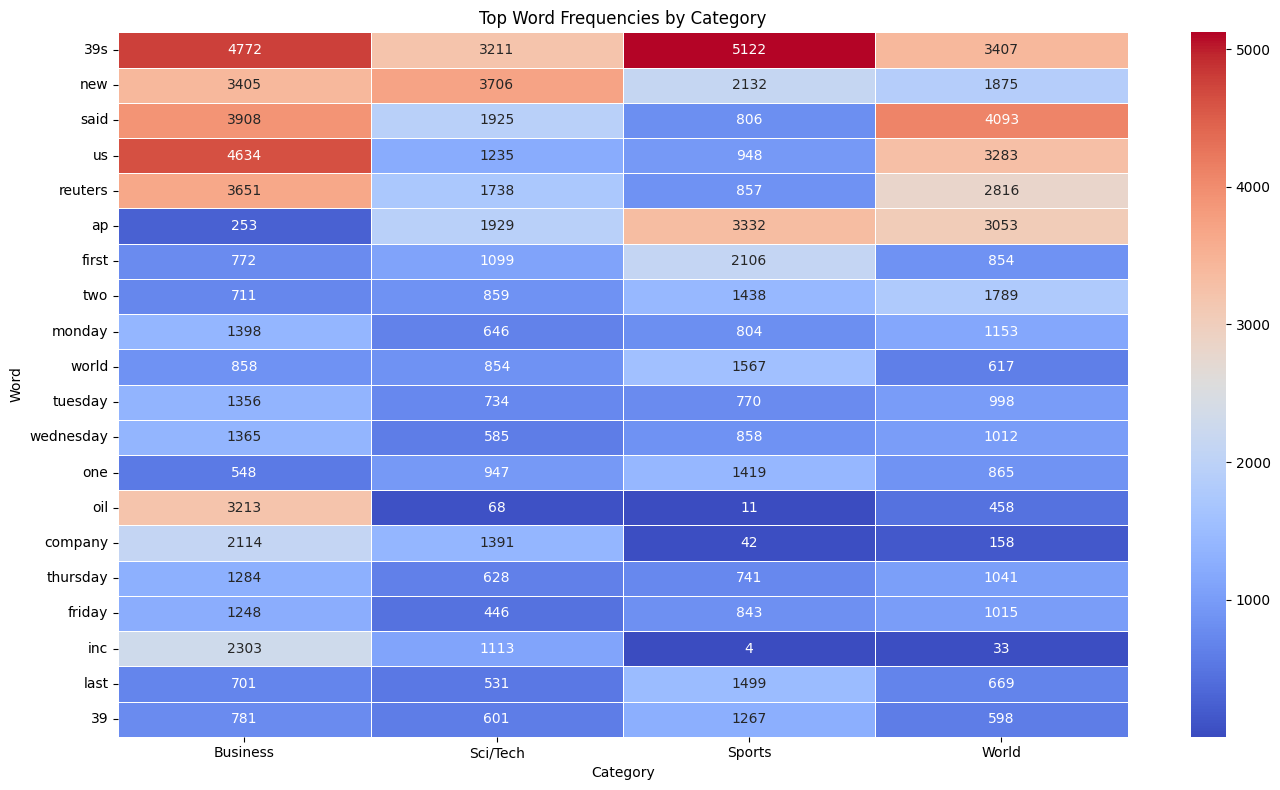

In [ ]:


#  Create a word frequency dictionary per category
category_words = df.groupby('label_name')['clean_text'].apply(lambda x: ' '.join(x).lower().split())

#  Count word frequencies per category
category_freqs = {}
for label, words in category_words.items():
    category_freqs[label] = Counter(words)

#  Get top N words across all categories
top_n = 20
all_words = sum(category_freqs.values(), Counter())
top_words = [word for word, _ in all_words.most_common(top_n)]

#  Build frequency matrix
freq_matrix = pd.DataFrame(index=top_words, columns=category_freqs.keys())
for label in category_freqs:
    for word in top_words:
        freq_matrix.loc[word, label] = category_freqs[label][word]

# Fill NaNs with 0 and convert to int
freq_matrix = freq_matrix.fillna(0).astype(int)

#  Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(freq_matrix, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Top Word Frequencies by Category')
plt.xlabel('Category')
plt.ylabel('Word')
plt.tight_layout()
plt.show()



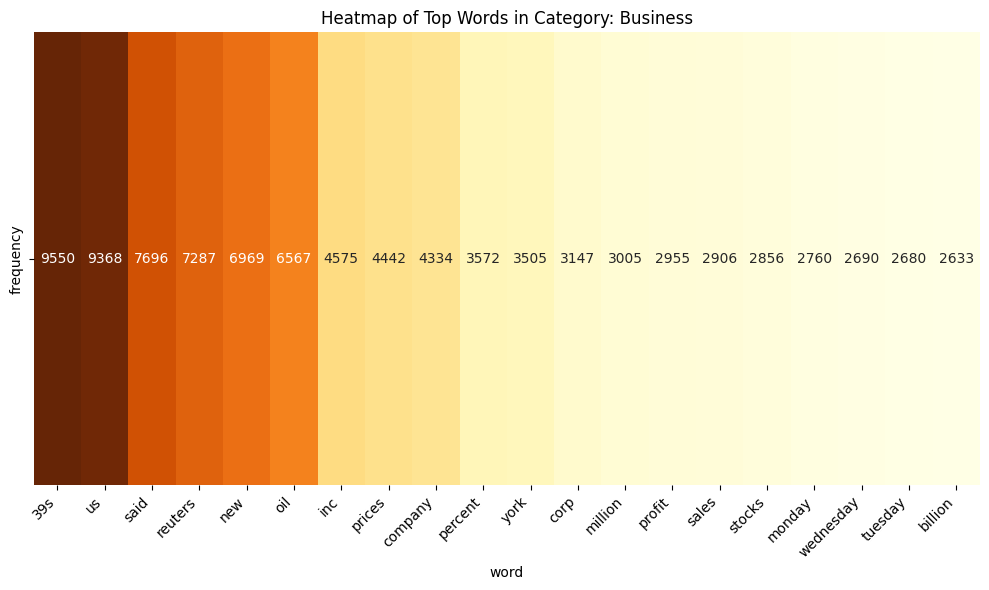

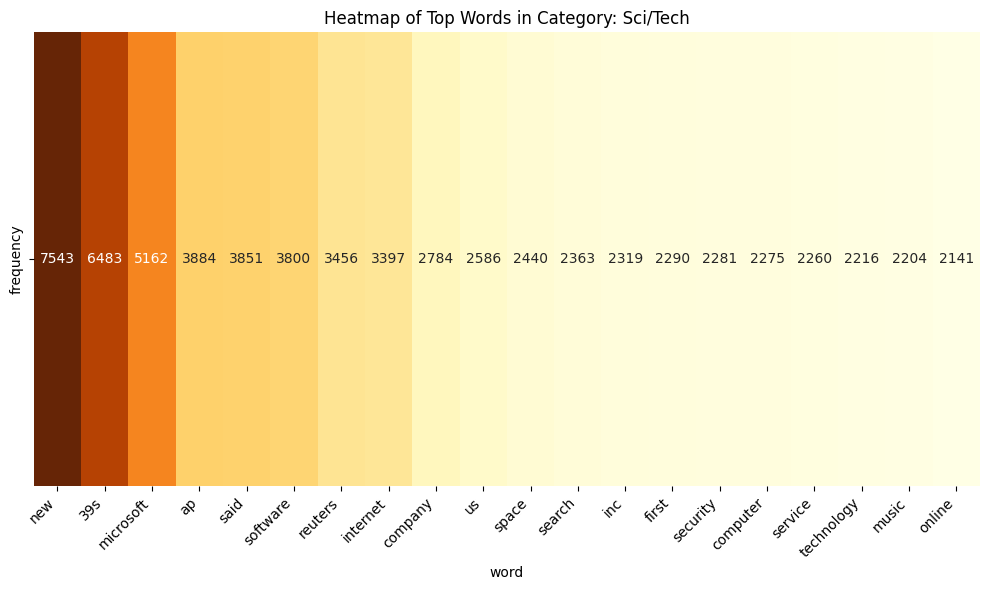

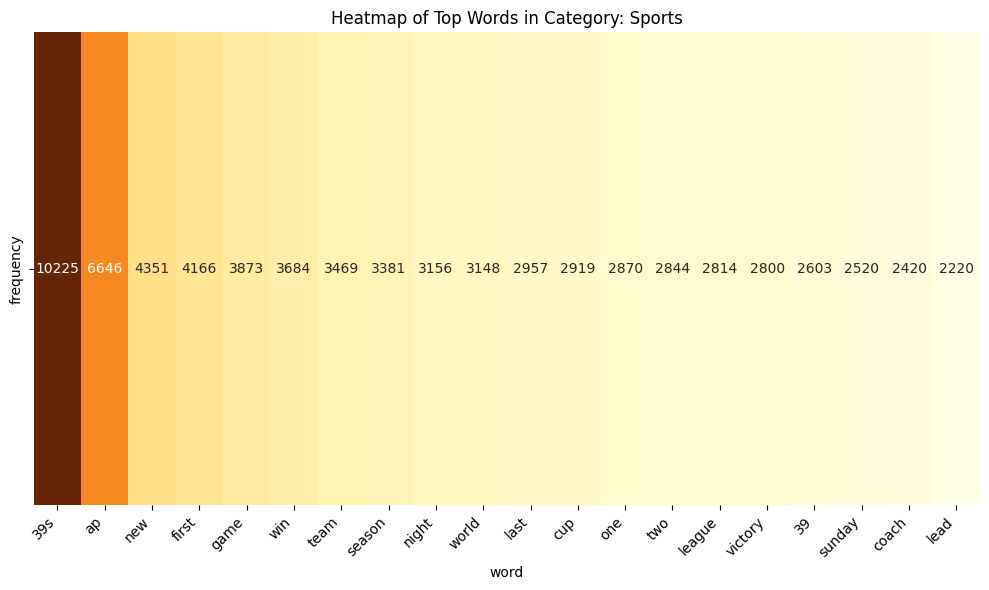

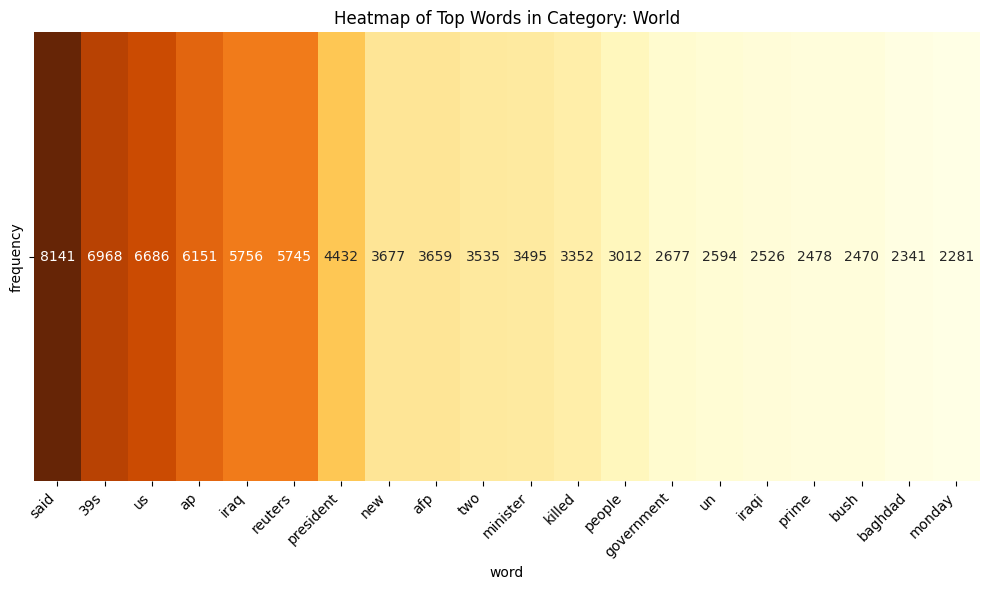

In [ ]:


#  Prepare word frequency per label
label_groups = df.groupby('label_name')['clean_text'].apply(lambda x: ' '.join(x).lower().split())

#  Loop through each label and generate heatmap
for label, words in label_groups.items():
    # Count word frequencies
    word_freq = Counter(words)
    top_words = word_freq.most_common(20)  # Top 20 words

    # Convert to DataFrame
    freq_df = pd.DataFrame(top_words, columns=['word', 'frequency']).set_index('word')

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(freq_df.T, cmap='YlOrBr', annot=True, fmt='d', cbar=False)
    plt.title(f'Heatmap of Top Words in Category: {label}')
    plt.yticks(rotation=90)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



In [ ]:
print(df.columns)

Index(['Title', 'Description', 'text', 'label'], dtype='object')


In [ ]:
df['label'].value_counts()

,count
label,
2,31900
3,31900
1,31900
0,31900


In [ ]:
# Initialize empty list to store sampled rows
sampled_rows = []

# Loop over each label
for label in [0, 1, 2, 3]:
    label_rows = df[df["label"] == label]
    print(f"Found {len(label_rows)} rows with label {label}")

    # Sample 50% of rows for the label
    rows_to_delete = label_rows.sample(frac=0.5, random_state=42)
    print(f"Sampling {len(rows_to_delete)} rows from label {label}")

    # Save sampled rows to list
    sampled_rows.append(rows_to_delete)

    # Remove sampled rows from original df
    df = df.drop(rows_to_delete.index)

# Combine original df (with sampled rows removed) and the sampled rows
df = pd.concat([df] + sampled_rows, ignore_index=True).reset_index(drop=True)

Found 31900 rows with label 0
Sampling 15950 rows from label 0
Found 31900 rows with label 1
Sampling 15950 rows from label 1
Found 31900 rows with label 2
Sampling 15950 rows from label 2
Found 31900 rows with label 3
Sampling 15950 rows from label 3


In [ ]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove emojis
    text = emoji.replace_emoji(text, replace='')

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Lowercase everything
    text = text.lower()

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

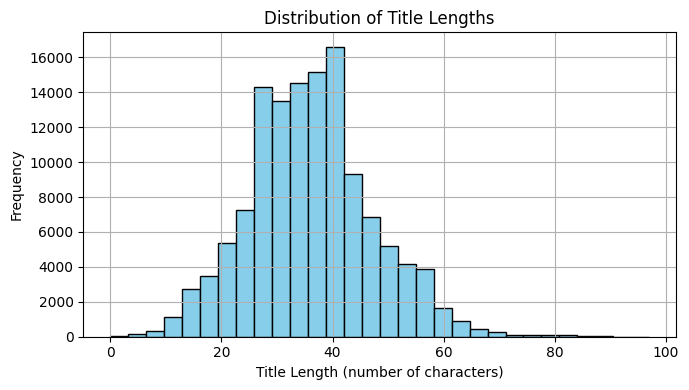

In [ ]:
df['title_length'] = df['clean_title'].astype(str).apply(len)

# Step 2: Plot histogram
plt.figure(figsize=(7, 4))
plt.hist(df['title_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length (number of characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

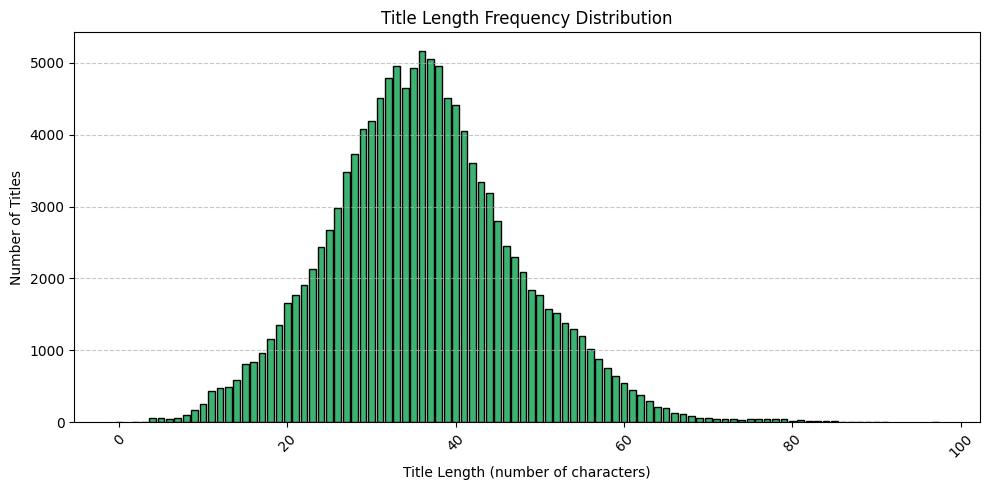

In [ ]:

df['title_length'] = df['clean_title'].astype(str).apply(len)

# Count frequency of each title length
length_counts = df['title_length'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(length_counts.index, length_counts.values, color='mediumseagreen', edgecolor='black')
plt.title('Title Length Frequency Distribution')
plt.xlabel('Title Length (number of characters)')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



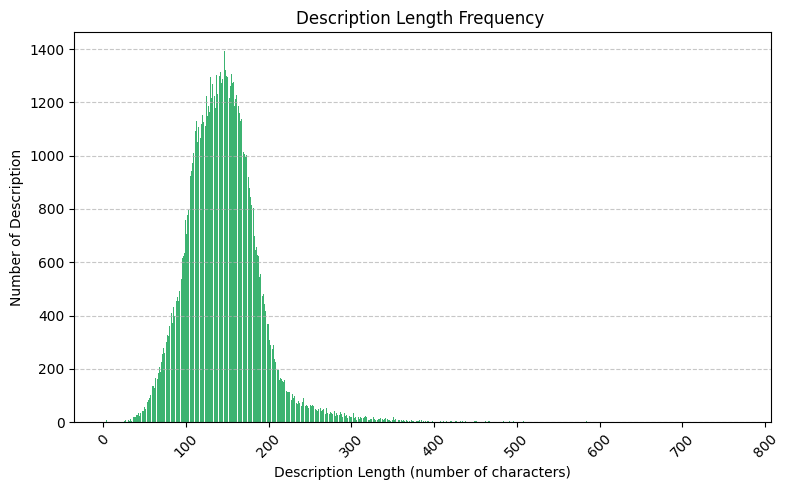

In [ ]:
df['Description_length'] = df['clean_Description'].astype(str).apply(len)

# Count frequency of each title length
length_counts = df['Description_length'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(length_counts.index, length_counts.values, color='mediumseagreen')
plt.title('Description Length Frequency ')
plt.xlabel('Description Length (number of characters)')
plt.ylabel('Number of Description')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

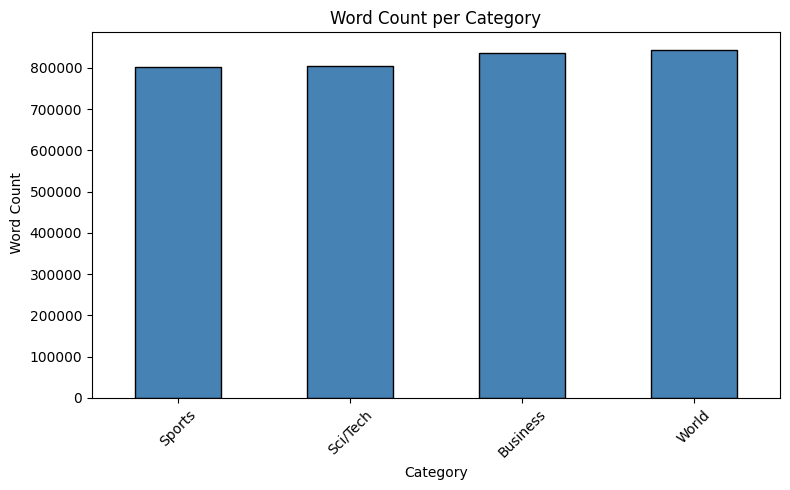

In [ ]:
df['word_count'] = df['clean_text'].astype(str).apply(lambda x: len(x.split()))

# Group by label_name and calculate average word count
word_count = df.groupby('label_name')['word_count'].sum().sort_values()

# Plot bar chart
plt.figure(figsize=(8, 5))
word_count.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Word Count per Category')
plt.xlabel('Category')
plt.ylabel(' Word Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [ ]:
avg_word_count = round(df['word_count'].mean())
print(avg_word_count)

26


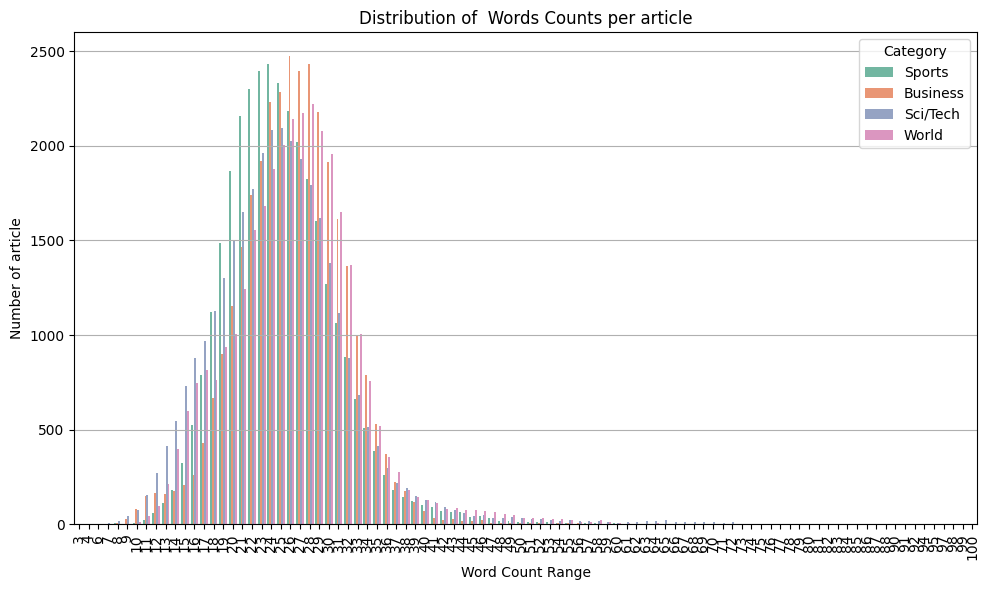

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='word_count', hue='label_name', palette='Set2')
plt.title('Distribution of  Words Counts per article')
plt.xlabel('Word Count Range')
plt.ylabel('Number of article')
plt.legend(title='Category')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



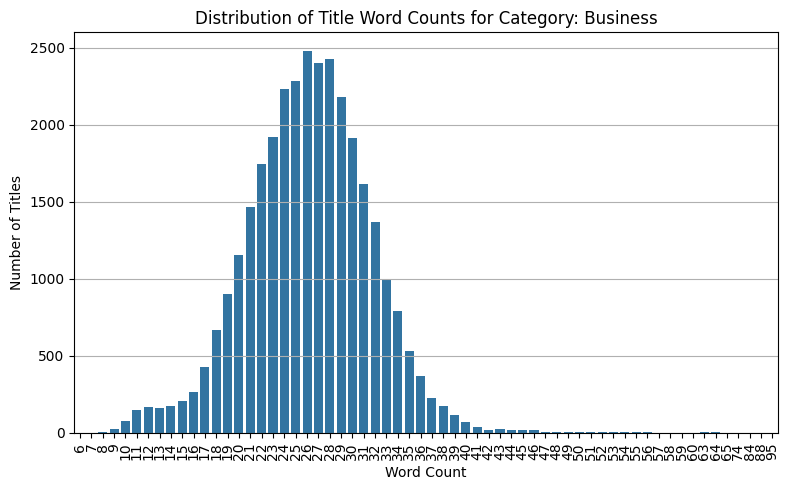

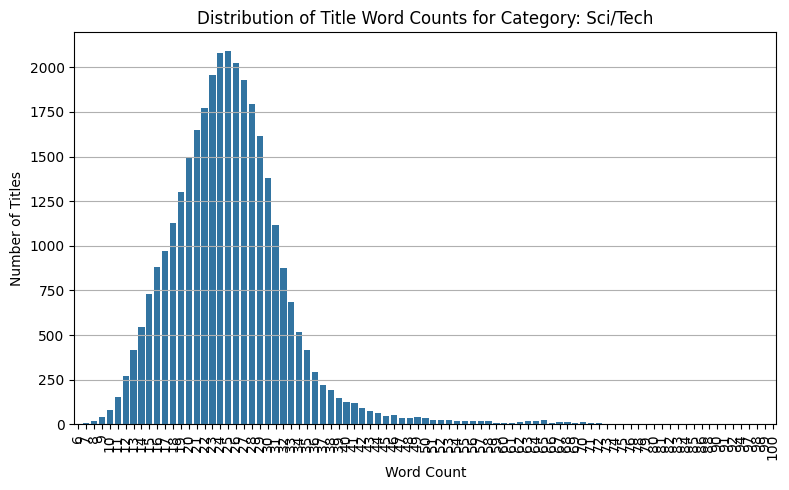

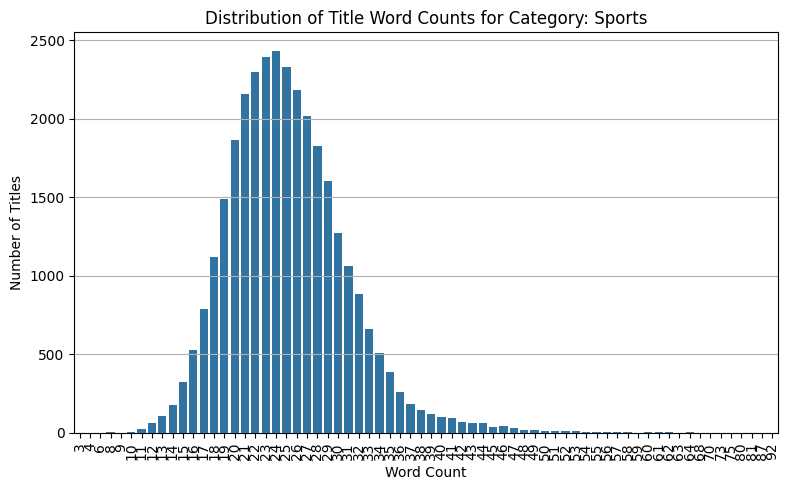

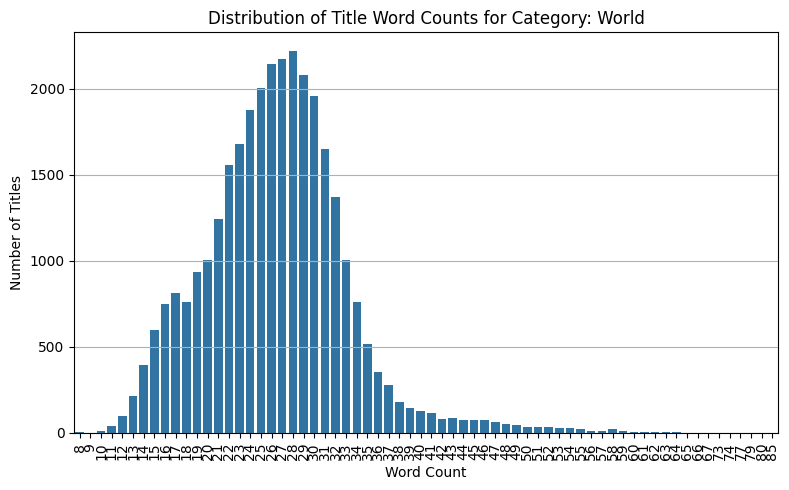

In [ ]:


# Get unique labels
unique_labels = df['label_name'].unique()

# Loop through each label and plot word count distribution
for label in unique_labels:
    # Filter data for the current label
    subset = df[df['label_name'] == label]

    # Plot
    plt.figure(figsize=(8, 5))
    sns.countplot(data=subset, x='word_count')
    plt.title(f'Distribution of Title Word Counts for Category: {label}')
    plt.xlabel('Word Count')
    plt.ylabel('Number of Titles')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()




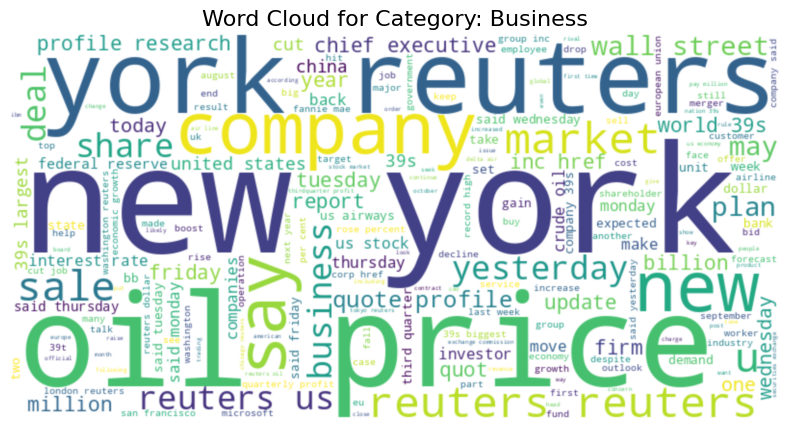

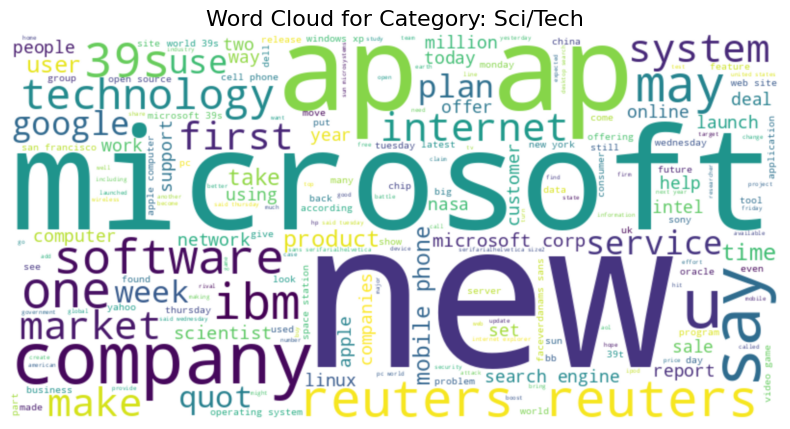

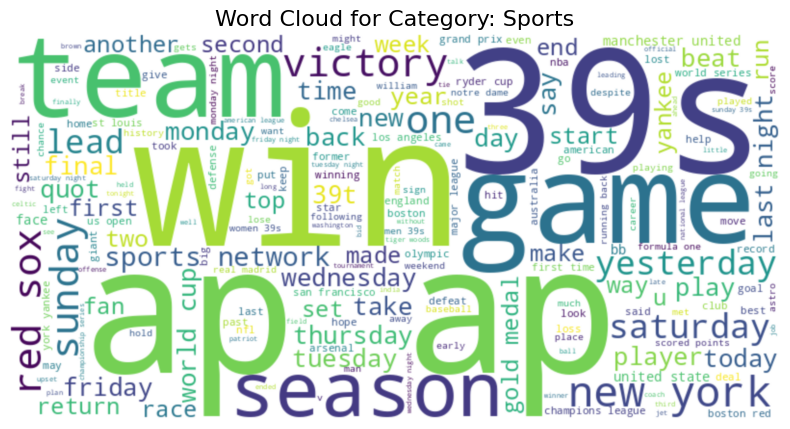

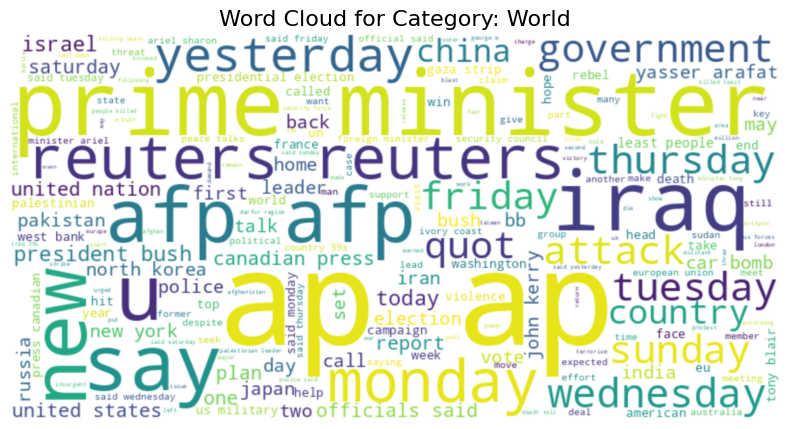

In [ ]:
from wordcloud import WordCloud

label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

# Assuming your DataFrame is called df and has a column named 'label'
df['label_name'] = df['label'].map(label_map)


grouped = df.groupby('label_name')['clean_text'].apply(lambda x: ' '.join(x))

# Generate word cloud for each category
for category, text in grouped.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bicubic')
    plt.axis('off')
    plt.title(f'Word Cloud for Category: {category}', fontsize=16)
    plt.show()

In [ ]:
print(len(df['clean_text']))

63800


In [ ]:
df['label'].value_counts()

,count
label,
0,15950
1,15950
2,15950
3,15950


- TF-IDF Vectorization: Transforms your cleaned text into numerical features that reflect word importance across documents.


- Feature Limit: max_features=50000 helps control dimensionality and keeps things efficient.


- Label Extraction: y = df['label'] grabs your class targets for training.


- Train-Test Split: The classic 80/20 split with a fixed random_state ensures reproducibility.


In [ ]:


# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=50000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(len(vectorizer.vocabulary_))


50000


In [ ]:
feature_names = vectorizer.get_feature_names_out()
print("Sample features:", feature_names[:10])

Sample features: ['00' '000' '0013hk' '002' '0029' '0032' '005' '005930ks' '007' '007style']


In [ ]:
# Initialize and train
model = LogisticRegression(C=1,max_iter=1000)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.9076802507836991
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      3162
           1       0.94      0.98      0.96      3176
           2       0.88      0.88      0.88      3240
           3       0.88      0.89      0.89      3182

    accuracy                           0.91     12760
   macro avg       0.91      0.91      0.91     12760
weighted avg       0.91      0.91      0.91     12760



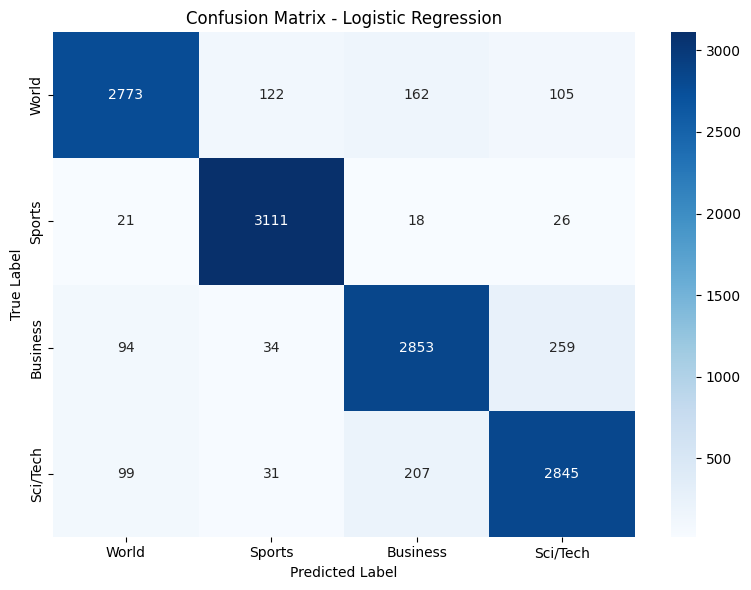

In [ ]:


# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

#  Optional: define class labels
labels = ["World", "Sports", "Business", "Sci/Tech"]  # Adjust if needed

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

In [ ]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Classification report
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.8702194357366771
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3162
           1       0.89      0.96      0.93      3176
           2       0.84      0.84      0.84      3240
           3       0.85      0.83      0.84      3182

    accuracy                           0.87     12760
   macro avg       0.87      0.87      0.87     12760
weighted avg       0.87      0.87      0.87     12760

Confusion Matrix:
 [[2668  173  190  131]
 [  49 3058   27   42]
 [ 115   91 2736  298]
 [ 144  110  286 2642]]


In [ ]:


# Initialize and train the model
xgb_model = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:24:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8917711598746082
Confusion Matrix:
 [[2752  126  148  136]
 [  41 3063   32   40]
 [ 101   46 2804  289]
 [ 113   64  245 2760]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      3162
           1       0.93      0.96      0.95      3176
           2       0.87      0.87      0.87      3240
           3       0.86      0.87      0.86      3182

    accuracy                           0.89     12760
   macro avg       0.89      0.89      0.89     12760
weighted avg       0.89      0.89      0.89     12760



In [ ]:
joblib.dump(xgb_model, 'XGBOOST_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer(50000).pkl')
joblib.dump(model, 'LogisticRegressor_model.pkl')



['LogisticRegressor_model.pkl']

In [ ]:
def preprocess_article(article_text):
    cleaned = clean_text(article_text)
    vectorized = vectorizer.transform([cleaned])
    return vectorized



In [ ]:
def predict_article_category(article_text):
    # Define label-to-category mapping
    label_map = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Sci/Tech"
    }

    # Preprocess and predict
    X_input = preprocess_article(article_text)
    prediction = xgb_model.predict(X_input)[0]

    # Return category name
    return label_map.get(prediction, "Unknown")
article = "NASA announces new mission to explore Jupiter's moons."
category = predict_article_category(article)
print("Predicted Category:", category)




Predicted Category: Sci/Tech


In [ ]:



#  Load and Prepare Dataset
texts = df['clean_text'].astype(str).tolist()
labels = df['label'].tolist()


#  Tokenize and Pad Sequences
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=30, padding='post')

#  Encode Labels (one-hot for categorical_crossentropy)
y = to_categorical(labels, num_classes=4)

#  Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Build Model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    LSTM(32),
    Dense(4, activation='softmax')  # 4 for number of classes
])

#  Compile Model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#  Training with Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[early_stop, lr_scheduler],
    batch_size=32
)

Epoch 1/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7857 - loss: 0.5584 - val_accuracy: 0.8895 - val_loss: 0.3175 - learning_rate: 0.0010
Epoch 2/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9284 - loss: 0.2249 - val_accuracy: 0.8960 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 3/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9448 - loss: 0.1752 - val_accuracy: 0.8964 - val_loss: 0.3336 - learning_rate: 0.0010
Epoch 4/10
1591/1595 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9580 - loss: 0.1311
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9580 - loss: 0.1311 - val_accuracy: 0.8939 - val_loss: 0.3555 - learning_rate: 0.0010
Epoch 5/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9749 - loss: 0.0769 - val_accuracy: 0.8939 - val_loss: 0.4668 - learning_rate: 5.0000e-04


In [ ]:


# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # Since you used one-hot encoding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Precision, Recall, F1 (per class + macro/micro averaging)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")

# Detailed Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.8960031347962383
Macro Precision: 0.8960
Macro Recall:    0.8963
Macro F1 Score:  0.8957

Classification Report:
               precision    recall  f1-score   support

           0     0.9109    0.8760    0.8931      3162
           1     0.9338    0.9776    0.9552      3176
           2     0.8835    0.8426    0.8626      3240
           3     0.8559    0.8887    0.8720      3182

    accuracy                         0.8960     12760
   macro avg     0.8960    0.8963    0.8957     12760
weighted avg     0.8959    0.8960    0.8956     12760


Confusion Matrix:
 [[2770  125  166  101]
 [  32 3105   23   16]
 [ 107   44 2730  359]
 [ 132   51  171 2828]]


399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


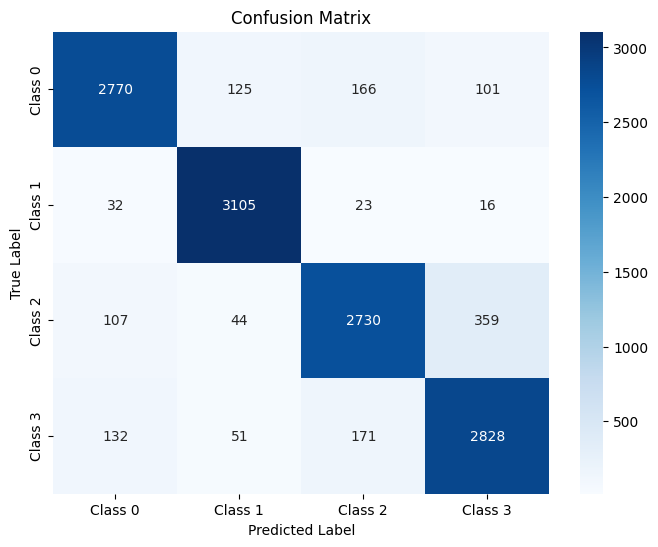

In [ ]:


# Convert one-hot labels to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(4)],
            yticklabels=[f'Class {i}' for i in range(4)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:




#  Build GRU Model
model1 = Sequential([
    Embedding(input_dim=50000, output_dim=128),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.2),
    GRU(32),
    Dense(4, activation='softmax')  # 4 units for 4-class output
])

#  Compile Model
model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#  Training with Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)


# Predict probabilities
y_pred_probs = model1.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # Since you used one-hot encoding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Precision, Recall, F1 (per class + macro/micro averaging)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")

# Detailed Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

Epoch 1/20
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.7231 - loss: 0.6440 - val_accuracy: 0.9091 - val_loss: 0.2716 - learning_rate: 0.0010
Epoch 2/20
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.9508 - loss: 0.1536 - val_accuracy: 0.9092 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 3/20
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9750 - loss: 0.0775 - val_accuracy: 0.8960 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 4/20
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9848 - loss: 0.0454
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9848 - loss: 0.0454 - val_accuracy: 0.8942 - val_loss: 0.4499 - learning_rate: 0.0010
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.9090909090909091
Macro Precision: 0.9105
Macro Recall:    0.9091
Macro F1 Score:  0.9092

Classification Report:
               precision    recall  f1-score   support



399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


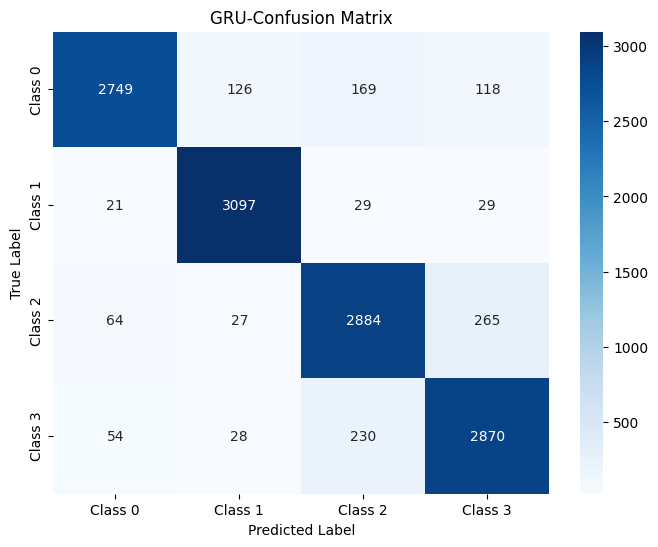

In [ ]:


# Convert one-hot labels to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model1.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(4)],
            yticklabels=[f'Class {i}' for i in range(4)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GRU-Confusion Matrix")
plt.show()

In [ ]:
import joblib

joblib.dump(model1, "GRU_model.pkl")

['GRU_model.pkl']

In [ ]:
model1.save("GRU_model1.h5")



In [ ]:
from transformers import DistilBertModel

distilbert_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')



In [ ]:
!pip install --upgrade transformers

In [ ]:


#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Tokenize with fixed padding
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

#  DistilBERT encoder
def distilbert_encoder():
    bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

    def extract_cls_token(inputs):
        input_ids, attention_mask = inputs
        output = bert_model(input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]  # CLS token
        return cls_token

    return Lambda(extract_cls_token, output_shape=(768,))

#  Build model
input_ids = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(128,), dtype='int32', name='attention_mask')

cls_output = distilbert_encoder()([input_ids, attention_mask])
output = Dense(y_train.shape[1], activation='softmax')(cls_output)

model2 = Model(inputs=[input_ids, attention_mask], outputs=output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#  Train
model2.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=32
)

# Evaluate
y_pred_probs = model2.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was tr

Epoch 1/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 248s 189ms/step - accuracy: 0.8248 - loss: 0.5454 - val_accuracy: 0.8858 - val_loss: 0.3469
Epoch 2/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 221s 159ms/step - accuracy: 0.8867 - loss: 0.3356 - val_accuracy: 0.8871 - val_loss: 0.3297
Epoch 3/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 262s 159ms/step - accuracy: 0.8920 - loss: 0.3187 - val_accuracy: 0.8906 - val_loss: 0.3217
319/319 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step
Accuracy: 0.8905760188087775
Macro Precision: 0.8911
Macro Recall:    0.8906
Macro F1 Score:  0.8906

Classification Report:
               precision    recall  f1-score   support

           0     0.9204    0.8699    0.8944      2552
           1     0.9557    0.9800    0.9677      2552
           2     0.8236    0.8527    0.8379      2552
           3     0.8648    0.8597    0.8623      2552

    accuracy                         0.8906     10208
   macro avg     0.8911    0.8906    0.8906     10208
weighted avg     0.8911    0.8906    0.8906     102

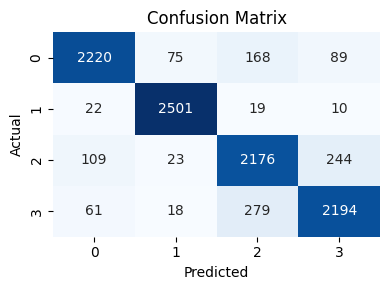

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
!pip install transformers==4.54.1

In [ ]:

df['label_id'] = LabelEncoder().fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Train-test split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='tf'
    )

train_encodings = tokenize(X_train_texts)
test_encodings = tokenize(X_test_texts)


bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")


def get_cls_embeddings_batched(encodings, batch_size=32):
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    num_samples = input_ids.shape[0]

    cls_embeddings = []

    for i in range(0, num_samples, batch_size):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_mask = attention_mask[i:i+batch_size]

        outputs = bert_model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask
        )
        cls_batch = outputs.last_hidden_state[:, 0, :]
        cls_embeddings.append(cls_batch)

    return tf.concat(cls_embeddings, axis=0)


X_train_embed = get_cls_embeddings_batched(train_encodings, batch_size=32)
X_test_embed = get_cls_embeddings_batched(test_encodings, batch_size=32)


input_layer = Input(shape=(768,))
output_layer = Dense(y_train.shape[1], activation='softmax')(input_layer)
classifier = Model(inputs=input_layer, outputs=output_layer)

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


classifier.fit(X_train_embed, y_train, validation_data=(X_test_embed, y_test), epochs=10, batch_size=32)



# Evaluate
y_pred_probs = classifier.predict(X_test_embed)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8341 - loss: 0.5172 - val_accuracy: 0.8861 - val_loss: 0.3366
Epoch 2/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8873 - loss: 0.3291 - val_accuracy: 0.8890 - val_loss: 0.3243
Epoch 3/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8903 - loss: 0.3205 - val_accuracy: 0.8907 - val_loss: 0.3156
Epoch 4/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8918 - loss: 0.3134 - val_accuracy: 0.8897 - val_loss: 0.3210
Epoch 5/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8946 - loss: 0.3049 - val_accuracy: 0.8924 - val_loss: 0.3101
Epoch 6/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8942 - loss: 0.3030 - val_accuracy: 0.8951 - val_loss: 0.3118
Epoch 7/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8967 - loss: 0.3016 - val_accuracy: 0.8921 - val_loss: 0.3105
Epoch 8/10
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8977 - loss: 0.2963 - 

In [ ]:
# 💾 Save model
classifier.save("bert_classifier.h5")

In [ ]:

label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Tokenize with BERT
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

#  BERT encoder
def bert_encoder():
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")

    def extract_cls_token(inputs):
        input_ids, attention_mask = inputs
        output = bert_model(input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]  # CLS token
        return cls_token

    return Lambda(extract_cls_token, output_shape=(768,))

# Build model
input_ids = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(128,), dtype='int32', name='attention_mask')

cls_output = bert_encoder()([input_ids, attention_mask])
output = Dense(y_train.shape[1], activation='softmax')(cls_output)

model3 = Model(inputs=[input_ids, attention_mask], outputs=output)
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model3.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=32
)


y_pred_probs = model3.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 476s 366ms/step - accuracy: 0.8122 - loss: 0.5567 - val_accuracy: 0.8733 - val_loss: 0.3697
Epoch 2/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 438s 318ms/step - accuracy: 0.8846 - loss: 0.3467 - val_accuracy: 0.8816 - val_loss: 0.3421
Epoch 3/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 440s 317ms/step - accuracy: 0.8880 - loss: 0.3249 - val_accuracy: 0.8853 - val_loss: 0.3323
319/319 ━━━━━━━━━━━━━━━━━━━━ 85s 256ms/step
Accuracy: 0.8852860501567398
Macro Precision: 0.8862
Macro Recall:    0.8853
Macro F1 Score:  0.8856

Classification Report:
               precision    recall  f1-score   support

           0     0.9109    0.8774    0.8938      2552
           1     0.9656    0.9667    0.9661      2552
           2     0.8153    0.8542    0.8343      2552
           3     0.8532    0.8429    0.8480      2552

    accuracy                         0.8853     10208
   macro avg     0.8862    0.8853    0.8856     10208
weighted avg     0.8862    0.8853    0.8856     102

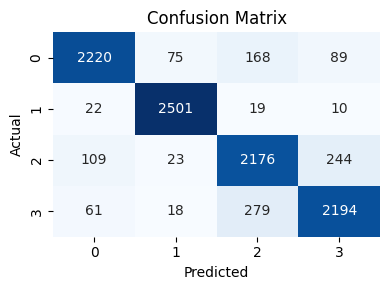

In [ ]:
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
model2.save("transformer_bert-base-uncased_model.h5")

In [ ]:
model_bert.save("transformer_fine_tuned_bert_model.h5")

In [ ]:


#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])  # 'label' column should contain category names
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Tokenize with RoBERTa
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

# RoBERTa encoder
def roberta_encoder():
    roberta_model = TFRobertaModel.from_pretrained("roberta-base")

    def extract_cls_token(inputs):
        input_ids, attention_mask = inputs
        output = roberta_model(input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]  # CLS token
        return cls_token

    return Lambda(extract_cls_token, output_shape=(768,))

#  Build model
input_ids = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(128,), dtype='int32', name='attention_mask')

cls_output = roberta_encoder()([input_ids, attention_mask])
output = Dense(y_train.shape[1], activation='softmax')(cls_output)

model_roberta = Model(inputs=[input_ids, attention_mask], outputs=output)
model_roberta.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#  Train
history = model_roberta.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=32
)

#  Evaluate
y_pred_probs = model_roberta.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 381s 290ms/step - accuracy: 0.7352 - loss: 1.0565 - val_accuracy: 0.8579 - val_loss: 0.5695
Epoch 2/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 375s 288ms/step - accuracy: 0.8662 - loss: 0.5205 - val_accuracy: 0.8686 - val_loss: 0.4434
Epoch 3/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 382s 288ms/step - accuracy: 0.8714 - loss: 0.4284 - val_accuracy: 0.8736 - val_loss: 0.4015
319/319 ━━━━━━━━━━━━━━━━━━━━ 77s 226ms/step
Accuracy: 0.8736285266457681
Macro Precision: 0.8735
Macro Recall:    0.8736
Macro F1 Score:  0.8735

Classification Report:
               precision    recall  f1-score   support

           0     0.8677    0.8868    0.8771      2552
           1     0.9488    0.9510    0.9499      2552
           2     0.8283    0.8315    0.8299      2552
           3     0.8492    0.8252    0.8370      2552

    accuracy                         0.8736     10208
   macro avg     0.8735    0.8736    0.8735     10208
weighted avg     0.8735    0.8736    0.8735     102

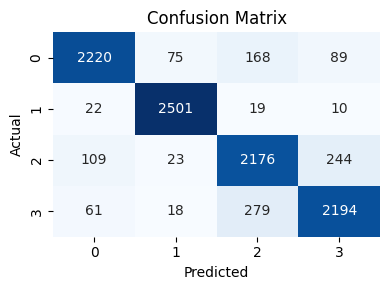

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
model2.save("transformer_roberta_model.h5")

In [ ]:


#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Load tokenizer from fine-tuned model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#  Tokenize
train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

from transformers import TFAutoModel

# Load base BERT model without classification head
base_model = TFAutoModel.from_pretrained(model_name)

from tensorflow.keras.layers import Lambda

# Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Lambda wrapper with explicit output shape
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    bert_output = base_model(input_ids, attention_mask=attention_mask)[0]
    return bert_output[:, 0, :]  # [CLS] token

cls_token = Lambda(
    bert_layer,
    output_shape=(base_model.config.hidden_size,)
)([input_ids, attention_mask])

# Classification head
output = Dense(y_train.shape[1], activation='softmax')(cls_token)

# Final model
model_bert2 = Model(inputs=[input_ids, attention_mask], outputs=output)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)

model_bert2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)






#  Train
history = model_bert2.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=32
)


#  Evaluate
y_pred_probs = model_bert2.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 474s 363ms/step - accuracy: 0.6432 - loss: 1.0150 - val_accuracy: 0.8039 - val_loss: 0.6158
Epoch 2/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 403s 316ms/step - accuracy: 0.8152 - loss: 0.5863 - val_accuracy: 0.8274 - val_loss: 0.5187
Epoch 3/3
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 442s 315ms/step - accuracy: 0.8333 - loss: 0.5117 - val_accuracy: 0.8398 - val_loss: 0.4801
319/319 ━━━━━━━━━━━━━━━━━━━━ 85s 256ms/step
Accuracy: 0.8398315047021944
Macro Precision: 0.8399
Macro Recall:    0.8398
Macro F1 Score:  0.8398

Classification Report:
               precision    recall  f1-score   support

           0     0.8551    0.8625    0.8588      2552
           1     0.9232    0.9228    0.9230      2552
           2     0.7779    0.7947    0.7862      2552
           3     0.8033    0.7794    0.7912      2552

    accuracy                         0.8398     10208
   macro avg     0.8399    0.8398    0.8398     10208
weighted avg     0.8399    0.8398    0.8398     102

In [ ]:


#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

# Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Load tokenizer from fine-tuned model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#  Tokenize
train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

from transformers import TFAutoModel


base_model = TFAutoModel.from_pretrained(model_name)

from tensorflow.keras.layers import Lambda

# Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Lambda wrapper with explicit output shape
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    bert_output = base_model(input_ids, attention_mask=attention_mask)[0]
    return bert_output[:, 0, :]  # [CLS] token

cls_token = Lambda(
    bert_layer,
    output_shape=(base_model.config.hidden_size,)
)([input_ids, attention_mask])

# Classification head
output = Dense(y_train.shape[1], activation='softmax')(cls_token)

# Final model
model_bert = Model(inputs=[input_ids, attention_mask], outputs=output)
model_bert.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])





# 🏋️ Train
history = model_bert.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=64
)


# 📊 Evaluate
y_pred_probs = model_bert.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
638/638 ━━━━━━━━━━━━━━━━━━━━ 393s 600ms/step - accuracy: 0.7523 - loss: 0.7142 - val_accuracy: 0.8542 - val_loss: 0.4353
Epoch 2/3
638/638 ━━━━━━━━━━━━━━━━━━━━ 435s 596ms/step - accuracy: 0.8578 - loss: 0.4257 - val_accuracy: 0.8634 - val_loss: 0.4013
Epoch 3/3
638/638 ━━━━━━━━━━━━━━━━━━━━ 374s 584ms/step - accuracy: 0.8654 - loss: 0.4004 - val_accuracy: 0.8676 - val_loss: 0.3861
319/319 ━━━━━━━━━━━━━━━━━━━━ 86s 257ms/step
Accuracy: 0.8675548589341693
Macro Precision: 0.8692
Macro Recall:    0.8676
Macro F1 Score:  0.8677

Classification Report:
               precision    recall  f1-score   support

           0     0.8853    0.8770    0.8811      2552
           1     0.9497    0.9463    0.9480      2552
           2     0.7858    0.8527    0.8179      2552
           3     0.8560    0.7943    0.8240      2552

    accuracy                         0.8676     10208
   macro avg     0.8692    0.8676    0.8677     10208
weighted avg     0.8692    0.8676    0.8677     10208


C

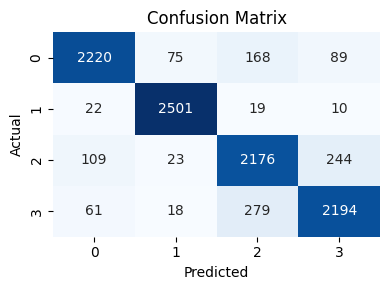

In [ ]:
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:

#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Load tokenizer from fine-tuned model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#  Tokenize
train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

from transformers import TFAutoModel

base_model = TFAutoModel.from_pretrained(
    model_name,
    from_pt=True
)


from tensorflow.keras.layers import Lambda

# Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Lambda wrapper with explicit output shape
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    bert_output = base_model(input_ids, attention_mask=attention_mask)[0]
    return bert_output[:, 0, :]  # [CLS] token

cls_token = Lambda(
    bert_layer,
    output_shape=(base_model.config.hidden_size,)
)([input_ids, attention_mask])

# Classification head
output = Dense(y_train.shape[1], activation='softmax')(cls_token)

# Final model
model_bert = Model(inputs=[input_ids, attention_mask], outputs=output)
model_bert.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])





# Train
history = model_bert.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=10,
    batch_size=32
)


#  Evaluate
y_pred_probs = model_bert.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 406s 309ms/step - accuracy: 0.7794 - loss: 0.6428 - val_accuracy: 0.8561 - val_loss: 0.4214
Epoch 2/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 392s 307ms/step - accuracy: 0.8633 - loss: 0.4110 - val_accuracy: 0.8569 - val_loss: 0.4080
Epoch 3/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 443s 308ms/step - accuracy: 0.8693 - loss: 0.3878 - val_accuracy: 0.8672 - val_loss: 0.3809
Epoch 4/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 442s 308ms/step - accuracy: 0.8721 - loss: 0.3744 - val_accuracy: 0.8752 - val_loss: 0.3673
Epoch 5/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 388s 304ms/step - accuracy: 0.8741 - loss: 0.3697 - val_accuracy: 0.8751 - val_loss: 0.3663
Epoch 6/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 448s 308ms/step - accuracy: 0.8754 - loss: 0.3652 - val_accuracy: 0.8774 - val_loss: 0.3626
Epoch 7/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 442s 308ms/step - accuracy: 0.8769 - loss: 0.3630 - val_accuracy: 0.8763 - val_loss: 0.3592
Epoch 8/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 442s 308ms/step - ac

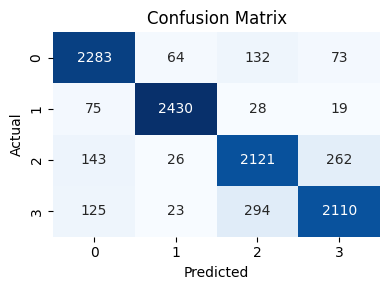

In [ ]:


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
import joblib

joblib.dump(model_bert, "transformer_bert(epoch=10)_model.pkl")

['transformer_bert(epoch=10)_model.pkl']

In [ ]:
model_bert.save("transformer_bert(epoch=10)_model.h5")

In [ ]:
from tabulate import tabulate

# Define the data
headers = ["Model Name", "Model Type", "Accuracy", "F1-Score", "Pros", "Cons"]
rows = [
    [
        "Logistic Regression", "ML", 0.90, 0.90,
        "1. Fast training and inference\n2. Easy to interpret and implement\n3. Good for linearly separable text",
        "1. Limited to linear decision boundaries\n2. Poor performance on long or complex text\n3. Requires manual feature engineering"
    ],
    [
        "GRU", "DL", 0.90, 0.90,
        "1. Captures sequential dependencies\n2. Handles variable-length input\n3. Suitable for moderately complex NLP tasks",
        "1. Slower training than ML models\n2. Sensitive to vanishing gradients\n3. Needs careful hyperparameter tuning"
    ],
    [
        "DistilBERT", "Pre-trained", 0.89, 0.89,
        "1. Excellent contextual understanding\n2. Pre-trained on large corpora\n3. High accuracy with fine-tuning",
        "1. High memory and compute requirements\n2. Slower inference speed\n3. May overfit on small datasets"
    ]
]

# Print the table
print("News Article Classifier Comparison:\n")
print(tabulate(rows, headers=headers, tablefmt="grid"))

News Article Classifier Comparison:

+---------------------+--------------+------------+------------+----------------------------------------------+---------------------------------------------+
| Model Name          | Model Type   |   Accuracy |   F1-Score | Pros                                         | Cons                                        |
+=====================+==============+============+============+==============================================+=============================================+
| Logistic Regression | ML           |       0.9  |       0.9  | 1. Fast training and inference               | 1. Limited to linear decision boundaries    |
|                     |              |            |            | 2. Easy to interpret and implement           | 2. Poor performance on long or complex text |
|                     |              |            |            | 3. Good for linearly separable text          | 3. Requires manual feature engineering      |
+--------------